# Import Libraries

In [1]:
# # Import Libraries
from __future__ import print_function
#import neptune
import os, sys, math
%matplotlib inline
import matplotlib.pyplot as plt
root   = os.path.abspath(os.getcwd())
print(root)
libs   = root + '/libs'
data   = root + '/data'
sys.path.append(libs)
sys.path.append(data)
from nn_utils import *
from utilsData import *
from utilsData import read_dataset
from utilsData import transform_labels
import keras
from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.models import Model
from keras.datasets import mnist
from keras.layers import *
from keras.utils import to_categorical
import pandas as pd
import json
import numpy as np
import ctypes
import sklearn
import plotly.graph_objects as go
import time
from IPython import display
from dtaidistance import dtw
from cobras_ts.cobras_dtw import COBRAS_DTW
from cobras_ts.notebookquerier_ts import NotebookQuerierTS

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

d:\cLLDProjekt\PythonSkripts


In [2]:
BASEDIR = os.path.join(os.getcwd(), '../SVEN_DATA/clld_DT_on_TB5/slow/data') 

analyzed = 0
tosmall = 0

data = {}
for i in range(8):
    data['A1W%d'%(i+1)] = {
        'diff1_max' : [],
        'timestamp' : [],
        'init_value' : [],
        'direction' : [],
        'threshold' : [],
        'index' : [],
        'before': [],
        'after' :[]
        }
test={}


cllData             =  pd.DataFrame()
for filename in os.listdir(BASEDIR):
    if not filename.endswith('.json'):
        continue

    tempName    = []
    tempName    = filename[:-5].split('-')
    # if len(tempName) == 2:
    #     date_time, address = filename[:-5].split('-')
    # else:
    date_time, address, test3 = filename[:-5].split('-')

    if test3 == '0':
        continue

    with open(os.path.join(BASEDIR, filename), 'r') as f:
        rdb = json.load(f)
 
        # fig = plt.figure()
        # ax = plt.axes()

        # ax.plot(rdb['data']);
        cllDataTemp         =  pd.DataFrame()
        cllDataTemp         = cllDataTemp.append(rdb['data'])
        cllData             = pd.concat([cllData, cllDataTemp.T], axis=0)

# Define Constants and Variables

In [3]:
# # Define Constants and Variables
dataRoot                            = "data"
dataset_name                        = 'Cloth'
rootWithSlash                       = dataRoot + '/'
dataTest                            = dataset_name + "_TEST.txt"
dataTrain                           = dataset_name + "_TRAIN.txt"

# Skript Constants
INTERPOLATION                       = 2
NUMBER_OF_SAMPLES_CNN               = 250
ADM_LOWER_LIMIT_INT_8               = 126
ADM_UPPER_LIMIT_INT_8               = ADM_LOWER_LIMIT_INT_8
MAX_NUMBER_OF_DATA_POINTS = 2927
budget                              = 100
alpha                               = 0.5
window                              = 5

pickleObjectNameW                   = '/lowstandardhighvolumetipswater.pkl'
pickleObjectNameG                   = '/lowstandardhighvolumetipsglycerin.pkl'

# Load Acquired Aspiration Data

In [4]:
# Load data from pickle Objects
sql_DF_Water                        = pd.read_pickle(dataRoot+pickleObjectNameW)
sql_DF_Glycerol                     = pd.read_pickle(dataRoot+pickleObjectNameG)
sql_DF                              = pd.concat([sql_DF_Glycerol, sql_DF_Water])

# Select just pressure datas
# sql_DFFilteredAsp                   = sql_DF.loc[sql_DF.loc[:,'J_Read Pressure Data Active'] == 1,:]
# # Select just class ids and pressure datas
# sql_DFFilteredAspColumns            = sql_DFFilteredAsp.iloc[:,-MAX_NUMBER_OF_DATA_POINTS:]
# Add Class id to dataframe
sql_DFFilteredAspColumns            = cllData 
sql_DFFilteredAspColumns['ClassId'] = 0
# Reset index
sql_DFFilteredAspColumns            = sql_DFFilteredAspColumns.reset_index()
sql_DFFilteredAspColumns            = sql_DFFilteredAspColumns.drop(['index'], axis=1)

# Different Aspiration Curves Raw Data

In [5]:
# # Load Acquired Aspiration Data
plt.close()
fig                                 = go.Figure()

title = 'cLLD Data'
# Add traces

for i in range(0, sql_DFFilteredAspColumns.shape[0]):
    # Normal Aspiration
    if int(sql_DFFilteredAspColumns.loc[i,'ClassId']) == 0:
        fig.add_trace(go.Scatter(x=np.arange(len(np.array(sql_DFFilteredAspColumns.iloc[i,:]))), y=np.array(sql_DFFilteredAspColumns.iloc[i,:]),name='Data',
                                 line=dict(color='rgb(0,0,0)', width=1)))
    # Air Aspiration
    elif int(sql_DFFilteredAspColumns.loc[i,'ClassId']) == 1:
        fig.add_trace(go.Scatter(x=np.arange(len(np.array(sql_DFFilteredAspColumns.iloc[i,:]))), y=np.array(sql_DFFilteredAspColumns.iloc[i,:]),name='Asp. Air',
                                 line=dict(color='rgb(255,0,0)', width=1)))
    # Cloth Aspiration
    elif int(sql_DFFilteredAspColumns.loc[i,'ClassId']) == 2:
        fig.add_trace(go.Scatter(x=np.arange(len(np.array(sql_DFFilteredAspColumns.iloc[i,:]))), y=np.array(sql_DFFilteredAspColumns.iloc[i,:]),name='Asp. Cloth',
                                 line=dict(color='rgb(0,0,255)', width=1)))


annotations                         = []

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,
                   yaxis_title='Capacity [cap]',
                   xaxis_title='Number of Samples [N] ')

fig.show()

# Scale Time Data to 250 Points

Two different pressure data cases are possible
 - Aspiration pressure curve contains less than 250 points -> upsampling case
 - Aspiration pressure curve contains more than 250 points -> Downsampling case
 
The idea for this problem is to transform a digital signal to a nearly continuous signal by interpolation and resample it such that the whole curve in time contains 250 samples.

# Linear Interpolation of Curve

In [6]:
# # Linear Interpolation of Curve
sql_DFFilteredAspColumnsCopy                = sql_DFFilteredAspColumns.copy()
sql_DFFilteredAspColumnsCopy                = sql_DFFilteredAspColumnsCopy.drop(['ClassId'], axis= 1)
newDataframe                                = sql_DFFilteredAspColumnsCopy
for interpol in range(0,INTERPOLATION):
    newDataframe                            = pd.DataFrame()
    for i in range(0, sql_DFFilteredAspColumns.shape[0]):
        sql_DFFilteredAspColumnsWithoutNan  = np.array(sql_DFFilteredAspColumnsCopy.iloc[i,:].dropna())
        dataNumberingArray                  = np.arange(len(sql_DFFilteredAspColumnsWithoutNan)) + 1
        zeroPaddedData                      = np.insert(sql_DFFilteredAspColumnsWithoutNan, dataNumberingArray, 0)
        x = 0
        while x < (len(zeroPaddedData) - 2):
            zeroPaddedData[x + 1]           = ((zeroPaddedData[x] - zeroPaddedData[x + 2]) / 2.0) + zeroPaddedData[x + 2]
            x = x + 2

        interpolatedData                    = pd.DataFrame(zeroPaddedData)
        interpolatedDataT                   = interpolatedData.T

        newDataframe                        = pd.concat([newDataframe, interpolatedDataT])

    newDataframe                            = newDataframe.reset_index()
    newDataframe                            = newDataframe.drop(['index'], axis=1)

    sql_DFFilteredAspColumnsCopy            = newDataframe  


# Resample Curves Such That Wohle Curve Is Sampled Equally

In [7]:
# # Resample Curves Such That Wohle Curve Is Sampled Equally
totalResampledData                          = pd.DataFrame()
for i in range(0, sql_DFFilteredAspColumns.shape[0]):
    sampleLengthInterpolatedCurve           = len(sql_DFFilteredAspColumnsCopy.iloc[i, :].dropna())
    numberOfOffsetSamples                   = sampleLengthInterpolatedCurve/NUMBER_OF_SAMPLES_CNN
    sampleIteration                         = 0
    newDataframeWithoutNan                  = sql_DFFilteredAspColumnsCopy.iloc[i, :].dropna()
    resampledData                           = []
    for k in range(0, NUMBER_OF_SAMPLES_CNN):
        resampledData.append(newDataframeWithoutNan[int(sampleIteration)])
        sampleIteration                    +=numberOfOffsetSamples

    resampledDataPd                         = pd.DataFrame(np.array(resampledData))
    totalResampledData                      = pd.concat([totalResampledData, resampledDataPd.T])

totalResampledData                          = totalResampledData.reset_index()
totalResampledData                          = totalResampledData.drop(['index'], axis=1)
sql_DFFilteredAspColumnsResIndex            = sql_DFFilteredAspColumns.reset_index()
sql_DFFilteredAspColumnsResIndex            = sql_DFFilteredAspColumnsResIndex.drop(['index'], axis=1)
totalResampledData['ClassId']               = list(sql_DFFilteredAspColumnsResIndex.loc[:,'ClassId'])
# Make sure ClassId stands at first position
totalResampledDataColumns                   = totalResampledData.columns.tolist()
totalResampledDataColumns                   = totalResampledDataColumns[-1:] + totalResampledDataColumns[:-1]
totalResampledData                          = totalResampledData[totalResampledDataColumns]

# Save to CSV 

In [8]:
# # Save Data to CSV
halfOfSamples = int(len(totalResampledData)/2)

if len(totalResampledData) % 2: #ungrade
    totalResampledDataTrain = totalResampledData[:halfOfSamples]
    totalResampledDataTest  = totalResampledData[halfOfSamples:-1]
else:
    totalResampledDataTrain = totalResampledData[:halfOfSamples]
    totalResampledDataTest  = totalResampledData[halfOfSamples:]   

totalResampledDataTrain.to_csv(rootWithSlash+dataTest, index=False, header=False)
totalResampledDataTest.to_csv(rootWithSlash+dataTrain, index=False, header=False)

# Convert Test/Train Cap Level Json File to Dataframe and Numpy Array

In [9]:
# # convert Test/Train Cap Level Json File to Dataframe and Numpy Array
#Load text file
datasets_dict                               = read_dataset(dataRoot, dataset_name) 
x_train                                     = datasets_dict[dataset_name][0]
y_train                                     = datasets_dict[dataset_name][1]
x_test                                      = datasets_dict[dataset_name][2]
y_test                                      = datasets_dict[dataset_name][3]
y_trainClass                                = datasets_dict[dataset_name][1]
y_testClass                                 = datasets_dict[dataset_name][3]

nb_classes                                  = len(np.unique(np.concatenate((y_train,y_test),axis =0)))
# make the min to zero of labels
y_train,y_test                              = transform_labels(y_train,y_test)

# save orignal y because later we will use binary
y_true                                      = y_test.astype(np.int64) 
# transform the labels from integers to one hot vectors
enc                                         = sklearn.preprocessing.OneHotEncoder()
enc.fit(np.concatenate((y_train,y_test),axis =0).reshape(-1,1))
y_train                                     = enc.transform(y_train.reshape(-1,1)).toarray()
y_test                                      = enc.transform(y_test.reshape(-1,1)).toarray()

if len(x_train.shape) == 2: # if univariate 
    # add a dimension to make it multivariate with one dimension 
    x_train     = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
    x_test      = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

input_shape     = x_train.shape[1:]

# Scale Aspiration Data

\begin{align}
\Delta_s = max(S(t)) - min(S(t)) \\
S_s(t) = \frac{\Delta_{s128}}{\Delta_s} \Bigg(S(t) - \bigg|\frac{|max(S(t))| - |min(S(t))|}{2}\bigg|\Bigg) \hspace{1cm} |max(S(t))| > |min(S(t))|\\
S_s(t) = \frac{\Delta_{s128}}{\Delta_s} \Bigg(S(t) + \bigg|\frac{|max(S(t))| - |min(S(t))|}{2}\bigg|\Bigg) \hspace{1cm} |min(S(t))| > |max(S(t))|
\end{align}

where $S_s(t)$ defines the scaled pressure data, $S(t)$ defines the unscaled pressure data, $\Delta_{s128}$ the max range of a int_8 datatype (255) and $\Delta_s$ the max range of the unscaled pressure data $S(t)$

In [10]:
# # Visualize Scaled Data
plt.close()
fig = go.Figure()

title = 'Aspiration Curves Resampled (Ref. Classes)'
# Add traces

for i in range(0,x_test.shape[0]):
    # Normal Aspiration
    if int(y_testClass[i]) == 0:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=x_test[i,:].ravel(),name='Asp. Normal', 
                                 line=dict(color='rgb(0,0,0)', width=1)))
    # Air Aspiration
    elif int(y_testClass[i]) == 1:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=x_test[i,:].ravel(),name='Asp. Air', 
                                 line=dict(color='rgb(255,0,0)', width=1)))       
    # Cloth Aspiration
    elif int(y_testClass[i]) == 2:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=x_test[i,:].ravel(),name='Asp. Cloth', 
                                 line=dict(color='rgb(0,0,255)', width=1)))  
        
        
annotations = []        
        
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))        

fig.update_layout(annotations=annotations,
                   yaxis_title='Pressure [pa]',
                   xaxis_title='Number of Samples [N] ')

fig.show()

# Display Train X (Time) and Y (Normal-, Cloth-, Air-Aspiration)

In [11]:
# # Display Train X (Time) and Y (Normal-, Cloth-, Air-Aspiration)
fig = go.Figure()
title = 'Aspiration Curves Scaled Train (Ref. Classes)'
scaledTrain = x_train
# Add traces
for i in range(0,x_train.shape[0]):
    # Scale data
    temp        = []
    data        = x_train[i]
    delta_s     = max(data) - min(data)
    if(abs(max(data)) > abs(min(data))):
        tempScaled          = 253.0/delta_s * np.array(data) 
        scaledTrain[i,:]    = tempScaled + (ADM_UPPER_LIMIT_INT_8 - max(tempScaled))
    elif(abs(min(data)) > abs(max(data))): 
        tempScaled          = 253.0/delta_s * np.array(data) 
        scaledTrain[i,:]    = tempScaled + (-ADM_LOWER_LIMIT_INT_8 - min(tempScaled))
    
    # Normal Aspiration
    if int(y_trainClass[i]) == 0:
        fig.add_trace(go.Scatter(x=np.arange(len(x_train[i])), y=scaledTrain[i,:].ravel(),name='Asp. Normal', 
                                 line=dict(color='rgb(0,0,0)', width=1)))
    # Air Aspiration Aspiration
    elif int(y_trainClass[i]) == 1:
        fig.add_trace(go.Scatter(x=np.arange(len(x_train[i])), y=scaledTrain[i,:].ravel(),name='Asp. Air', 
                                 line=dict(color='rgb(255,0,0)', width=1)))       
    # Cloth Aspiration
    elif int(y_trainClass[i]) == 2 :
        fig.add_trace(go.Scatter(x=np.arange(len(x_train[i])), y=scaledTrain[i,:].ravel(),name='Asp. Cloth', 
                                 line=dict(color='rgb(0,0,255)', width=1)))  
        
annotations = []        
        
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.0,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))        

fig.update_layout(annotations=annotations,
                   yaxis_title='Pressure [pa]',
                   xaxis_title='Number of Samples [N] ')
fig.show()


# Display Test X (Time) and Y (Normal-, Cloth-, Air-Aspiration)

In [12]:
# # Display Test X (Time) and Y (Normal-, Cloth-, Air-Aspiration)
plt.close()
fig = go.Figure()

title = 'Aspiration Curves Scaled Test (Ref. Classes)'
scaledTest = x_test
# Add traces
for i in range(0,x_test.shape[0]):
    # Scale data
    temp        = []
    data        = x_test[i]
    delta_s     = max(data) - min(data)
    if(abs(max(data)) > abs(min(data))):
        tempScaled          = 253.0/delta_s * np.array(data) 
        scaledTest[i,:]    = tempScaled + (ADM_UPPER_LIMIT_INT_8 - max(tempScaled))
    elif(abs(min(data)) > abs(max(data))): 
        tempScaled          = 253.0/delta_s * np.array(data) 
        scaledTest[i,:]    = tempScaled + (-ADM_LOWER_LIMIT_INT_8 - min(tempScaled))

for i in range(0,x_test.shape[0]):
    # Normal Aspiration
    if int(y_testClass[i]) == 0:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=scaledTest[i,:].ravel(),name='Asp. Normal', 
                                 line=dict(color='rgb(0,0,0)', width=1)))
    # Air Aspiration
    elif int(y_testClass[i]) == 1:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=scaledTest[i,:].ravel(),name='Asp. Air', 
                                 line=dict(color='rgb(255,0,0)', width=1)))       
    # Cloth Aspiration
    elif int(y_testClass[i]) == 2:
        fig.add_trace(go.Scatter(x=np.arange(len(x_test[i])), y=scaledTest[i,:].ravel(),name='Asp. Cloth', 
                                 line=dict(color='rgb(0,0,255)', width=1)))  
        
        
annotations = []        
        
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))        

fig.update_layout(annotations=annotations,
                   yaxis_title='Pressure [pa]',
                   xaxis_title='Number of Samples [N] ')

fig.show()

## Cobras TS Automatic Clustering Algorithm As Data Verification

In [13]:
trainTestData   = np.vstack((scaledTrain, scaledTest))
permutation     = np.random.permutation(len(trainTestData))
dataLength      = 50
series          = trainTestData[permutation[:dataLength], :, :] # taking only the first 10 series for example purposes
seriesNew       = series.reshape(len(series), NUMBER_OF_SAMPLES_CNN)
#%% [markdown]
#Constructing the pairwise affinity matrix
dists           = dtw.distance_matrix(seriesNew, window=int(0.01 * window * seriesNew.shape[1]))
dists[dists == np.inf] = 0
dists           = dists + dists.T - np.diag(np.diag(dists))
affinities      = np.exp(-dists * alpha)

Constructing the pairwise affinity matrix

In [14]:

dists           = dtw.distance_matrix(seriesNew, window=int(0.01 * window * seriesNew.shape[1]))
dists[dists == np.inf] = 0
dists           = dists + dists.T - np.diag(np.diag(dists))
affinities      = np.exp(-dists * alpha)

## Starting the clustering process
Queried pairs will be plotted in the notebook
A must-link is given by entering 'Y' in the notebook prompt, a cannot-link by entering 'n'.
Each time an intermediate clustering is shown, you can decide to stop clustering (by entering 'n' in the prompt),\
or continue answering queries (by entering  'Y' in the prompt).

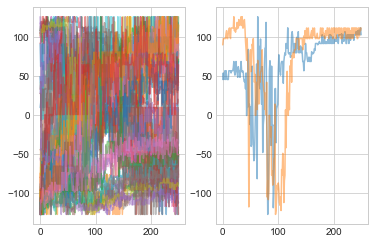

Continue querying? [Y/n] 

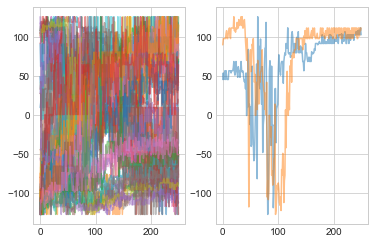

In [15]:

clusterer = COBRAS_DTW(affinities, NotebookQuerierTS(seriesNew), budget)
clustering, intermediate_clusterings, runtimes, ml, cl = clusterer.cluster()

## Return new classification back to data

In [16]:
clusteredLabel                                              = clustering.construct_cluster_labeling()
# Fill new classes
classes                                                     = np.empty(shape=[len(clusteredLabel), np.max(clusteredLabel)+1], dtype=int)
for i in range(0, len(clusteredLabel)):
    for j in range(0, np.max(clusteredLabel)+1):
        classes[i][j]   = 0
        if clusteredLabel[i] == j:           
            classes[i][j] = 1

numberOfClasses                                             = len(clusteredLabel)
numberOfClassesHalf                                         = int(numberOfClasses/2)
if numberOfClasses % 2:
    y_trainNew                                              = classes[:numberOfClassesHalf, :]
    y_testNew                                               = classes[numberOfClassesHalf:-1, :]
    x_trainNew                                              = series[:numberOfClassesHalf,:,:]
    x_testNew                                               = series[numberOfClassesHalf:-1,:,:]

else:
    y_trainNew                                              = classes[:numberOfClassesHalf, :]
    y_testNew                                               = classes[numberOfClassesHalf:, :]
    x_trainNew                                              = series[:numberOfClassesHalf,:,:]
    x_testNew                                               = series[numberOfClassesHalf:,:,:]

# Define Layers of CNN Algorithm

In [17]:
# # Define Layers of CNN Algorithm
#https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
def KModel(x_train, y_train, x_test, y_test, numberOfClasses):
    # Shuffle
    permutation = np.random.permutation(y_train.shape[0])
    x_train = x_train[permutation, :, :]
    y_train = y_train[permutation]
       
    inputs = Input(shape=x_train.shape[1:])
    # Layer Block 1
    x = Conv1D(32, kernel_size=(9), strides=(2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = ReLU()(x)
    x = MaxPool1D(2, strides=2)(x)

    # Layer Block 2
    x1 = Conv1D(32, kernel_size=(5), strides=(1), padding="same")(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.2)(x1)
    x1 = ReLU()(x1)
    x1 = MaxPool1D(2, strides=2)(x1)

    # Layer Block 3
    x2 = Conv1D(32, kernel_size=(3), strides=(1), padding="same")(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.2)(x2)
    x2 = ReLU()(x2)
    x2 = MaxPool1D(2, strides=2)(x2)

    # Layer Block 4
    x3 = MaxPool1D(2, strides=2)(x)
    x3 = Dropout(0.2)(x3)

    # concate all inception layers
    x = concatenate([ x1, x2,x3], axis=-1)

    # conclusion
    x = Conv1D(48, kernel_size=(3), strides=(1), padding="same")(x)
    x = ReLU()(x)
    x = MaxPool1D(2, strides=2)(x)
    x = Dropout(0.2)(x)

    # our netowrk is not that deep, so a hidden fully connected layer is introduce
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(0.2)(x)
    x = ReLU()(x)
    x = Dense(numberOfClasses)(x)
    y = Softmax()(x)
    
    model = Model(inputs=inputs, outputs=y)
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=16, epochs=100, shuffle=True, verbose=2, validation_data=(x_test, y_test))
    return model

# Train CNN Algorithm

In [18]:
if os.path.exists('.shift_list'):
    os.remove(".shift_list")
model = KModel(x_trainNew, y_trainNew, x_testNew, y_testNew, np.max(clusteredLabel)+1)
model.save(dataRoot+'model.h5')

Epoch 1/100
2/2 - 1s - loss: 3.4747 - accuracy: 0.1200 - val_loss: 0.9400 - val_accuracy: 0.9200
Epoch 2/100
2/2 - 0s - loss: 0.2221 - accuracy: 0.9200 - val_loss: 2.2726 - val_accuracy: 0.9200
Epoch 3/100
2/2 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.6878 - val_accuracy: 0.9200
Epoch 4/100
2/2 - 0s - loss: 2.1647e-04 - accuracy: 1.0000 - val_loss: 2.8997 - val_accuracy: 0.9200
Epoch 5/100
2/2 - 0s - loss: 8.7327e-05 - accuracy: 1.0000 - val_loss: 3.0137 - val_accuracy: 0.9200
Epoch 6/100
2/2 - 0s - loss: 1.9053e-05 - accuracy: 1.0000 - val_loss: 3.0706 - val_accuracy: 0.9200
Epoch 7/100
2/2 - 0s - loss: 1.1081e-05 - accuracy: 1.0000 - val_loss: 3.1087 - val_accuracy: 0.9200
Epoch 8/100
2/2 - 0s - loss: 1.9169e-06 - accuracy: 1.0000 - val_loss: 3.1323 - val_accuracy: 0.9200
Epoch 9/100
2/2 - 0s - loss: 8.0108e-07 - accuracy: 1.0000 - val_loss: 3.1251 - val_accuracy: 0.9200
Epoch 10/100
2/2 - 0s - loss: 5.5313e-07 - accuracy: 1.0000 - val_loss: 3.1110 - val_accuracy: 0.9200
E

# Generate C Code for NN Library and Transfer Weights File SVN

In [19]:
generate_model(model, x_testNew, name='NN_weights.h')

input_1 max value: 126.0 min value: -127.0 dec bit 0


TypeError: Expected float32 passed to parameter 'y' of op 'Equal', got <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001EB07613608> of type 'InputLayer' instead. Error: Expected float32, got <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001EB07613608> of type 'InputLayer' instead.